In [1]:
using Test
using StatsBase
using Distributions
using Plots
using FFTW


(process:15356): GLib-GIO-WARNING **: 18:31:43.656: Unexpectedly, UWP app `D5BE6627.UltraZipOpener_2.0.6.0_neutral__9pm2v9747qaaa' (AUMId `D5BE6627.UltraZipOpener_9pm2v9747qaaa!App') supports 127 extensions but has no verbs

(process:15356): GLib-GIO-WARNING **: 18:31:43.937: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs

(process:15356): GLib-GIO-WARNING **: 18:31:44.266: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


# Empirical distribution

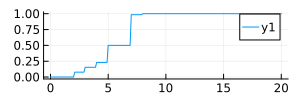

In [2]:
observations = [2.1, 3, 4, 5, 7, 8]
weights = Weights([1, 1, 1, 3.5, 6.3, 0.2])
empirical_distribution = ecdf(observations; weights)
xs = [i for i in 0:0.1:20]
ys = [empirical_distribution(x) for x in xs]
plot(xs,ys, size = (300, 100))

# Convolution of two distributions, FFT

In [3]:
function slow_convolution(v_1, v_2)
    for x in base_points_1
        l = div(x, step)
        tot = 0
        for i in 0:(l-1)
            tot += v_1[i + 1] * v_2[l-i]
        end
        push!(convolution, tot)
    end
    return convolution
end

slow_convolution (generic function with 1 method)

In [4]:
function fft_conv(d_1, d_2, limit)
    q = max(quantile(d_1, 1-limit), quantile(d_2, 1-limit))
    print(q)
    grid = 0:1:round(q)
    vector_values_1 = [pdf(d_1, x) for x in grid]
    vector_values_2 = [pdf(d_2, x) for x in grid]
    vector_conv = real(ifft(fft(vector_values_1).*fft(vector_values_2)))
    weights = Weights(vector_conv)
    return ecdf(grid; weights)
end

fft_conv (generic function with 1 method)

2000

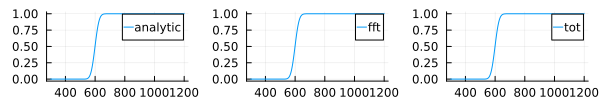

In [5]:
# standard convolution
b_1, b_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
cv_analytic = convolve(b_1, b_2)
cv_fft = fft_conv(b_1, b_2, 1e-30)
xs_test = 300:1200
p_analytic = plot(xs_test, [cdf(cv_analytic, x) for x in xs_test])
p_fft = plot(xs_test, [cv_fft(x) for x in xs_test])
p_tot = plot(xs_test, [cdf(Binomial(3000, 0.2), x) for x in xs_test])
plot(p_analytic, p_fft, p_tot, layout = (1, 3), size = (600, 100), label=["analytic" "fft" "tot"])

14881.002675202342

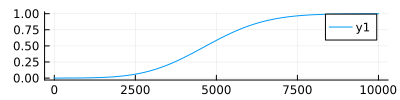

In [6]:
stp = 25
base_points = 0:stp:10000
conv = fft_conv(Gamma(100, 100), Gamma(80, 120), 0.00001)
plot(base_points, [conv(x) for x in base_points], size = (400, 100))

# Frequency-severity model

In [7]:
struct FrequencySeverity
    frequency
    severity
end

In [8]:
function StatsBase.rand(fs::FrequencySeverity)::Real
    tot = 0
    f = rand(fs.frequency)
    if f == 0 return 0 end
    for i in 1:f
        tot += rand(fs.severity)
    end
    return tot
end

function StatsBase.rand(fs::FrequencySeverity, n::Int)
    return [StatsBase.rand(fs) for x in 1:n]
end

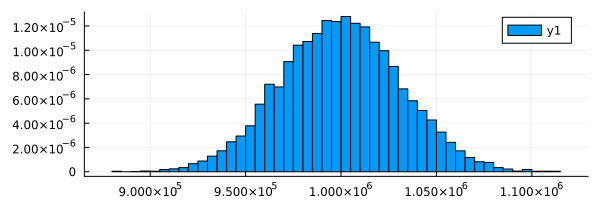

In [9]:
example_frequency = Poisson(1000)
example_severity = Gamma(100, 10)
ex_d = FrequencySeverity(example_frequency, example_severity)
draws = rand(ex_d, 10_000)
histogram(draws, norm = true, size = (600, 200))

### The quantile of a frequency-severity model

In [10]:
fs_pareto = Pareto(5, 1000)
fs_poisson = Poisson(40)
ex_fs = FrequencySeverity(fs_poisson, fs_pareto)
fs_draws = rand(ex_fs, 200_000)
ccdf = ecdf(fs_draws)

2000000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [11]:
quantile_fs_draws = findfirst(x -> x >= 0.999, [ccdf(x) for x in 1:200_000])

83411

In [12]:
quantile_approx = quantile(ex_fs.severity, 1 - (1 - 0.999)/mean(ex_fs.frequency)) + (mean(ex_fs.frequency) - 1)*mean(ex_fs.severity)

69662.79105124084

### Define moment-generating function for complex values

In [14]:
function Distributions.mgf(d::Poisson, t::Complex)
    λ = rate(d)
    return exp(λ * (exp(t) - 1))
end

### Apply FFT

In [71]:
α = 100
θ = 10
λ = 1000
fs = FrequencySeverity(Poisson(λ), Gamma(α, θ))

function empirical_quantile(freq_sev::FrequencySeverity, q::Real)
    if (q < 1e-6) & (q > (1 - 1e-6))
        throw(DomainError("The quantile is not in the acceptable range"))
    end
    n_trials = Int(ceil(1/(1 - q)))
    fs_draws = rand(ex_fs, n_trials)
    ccdf = ecdf(fs_draws)
    return Int(ceil(max(draws...)))
end


function FFTW.fft(freq_sev::FrequencySeverity)
    e_end = empirical_quantile(freq_sev, 0.9999)*2
    step_pdf = cdf.(freq_sev.severity, 1:(e_end - 1)) .- cdf.(freq_sev.severity, 0:(e_end - 2))
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(1:(e_end - 1); weights = real(ifft(total_claim_amount_ft)))
end

convolution_fs = fft(fs)

ECDF{UnitRange{Int64}, Weights{Float64, Float64, Vector{Float64}}}(1:2229503, [-8.266282758434323e-20, -8.156704485991644e-20, -8.33589867214095e-20, -8.181402981421504e-20, -8.370455633307774e-20, -8.240759107368751e-20, -8.285299439526317e-20, -8.34473647934447e-20, -8.209900690660715e-20, -8.236863642557347e-20  …  -8.24386591405683e-20, -8.373814735146685e-20, -8.244754467657604e-20, -8.195334137319493e-20, -8.106034446158534e-20, -8.195940508342525e-20, -8.31567973444642e-20, -8.206300413032419e-20, -8.33589791431803e-20, -8.32601413747788e-20])

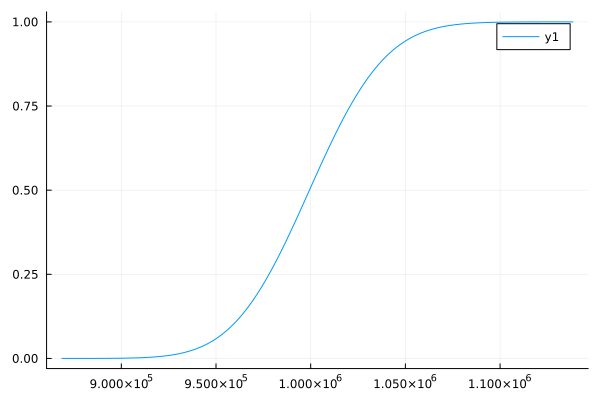

In [72]:
observation_plot = plot()

bot = first(Iterators.filter(x -> convolution_fs(x) > 0.00001, [t^2 for t in 0:100000]))


top = first(Iterators.filter(x -> convolution_fs(x) > 0.99999, [t^2 for t in 1:100000]))

plot!(bot:div(top - bot, 1000):top, [convolution_fs(x) for x in bot:div(top - bot, 1000):top])
display(observation_plot)

## How to determine the domain of plot?

### Panjer Algorithm